In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Reading and investigating the data

In [2]:
data = pd.read_csv('bankdata.csv')

In [3]:
data.shape

(74364, 9)

In [4]:
data.dtypes

type             object
operation        object
amount_total    float64
balance         float64
k_symbol         object
amount_left       int64
duration          int64
payments        float64
status           object
dtype: object

In [5]:
data.head()

,type,operation,amount_total,balance,k_symbol,amount_left,duration,payments,status
0,PRIJEM,prevod,44749.0,45549.0,unknown,79608,24,3317.0,A
1,PRIJEM,vklad,1000.0,1000.0,unknown,52788,12,4399.0,A
2,PRIJEM,vklad,1100.0,1100.0,unknown,21924,36,609.0,A
3,PRIJEM,vklad,700.0,700.0,unknown,23052,12,1921.0,A
4,PRIJEM,vklad,900.0,900.0,unknown,41904,12,3492.0,A


### Investigating the numerical variables

In [6]:
data.describe()

,amount_total,balance,amount_left,duration,payments
count,74364.000000,74364.000000,74364.000000,74364.000000,74364.000000
mean,7832.649125,46022.153061,102745.132645,23.942230,4356.580832
std,11729.040391,25439.948570,74749.275498,12.155783,2205.840892
min,0.000000,-14137.200000,4980.000000,12.000000,319.000000
25%,144.300000,27675.125000,46320.000000,12.000000,2569.000000
50%,3000.000000,40965.150000,86184.000000,24.000000,4051.000000
75%,9868.500000,60098.550000,140400.000000,36.000000,6315.000000
max,87300.000000,193910.000000,464520.000000,60.000000,9736.000000


#### Investigating variable duration

In [7]:
data['duration'].value_counts()

12    28761
24    25155
36    14110
48     4721
60     1617
Name: duration, dtype: int64

In [8]:
# we will convert this to a categorical
data['duration'] = data['duration'].apply(str)

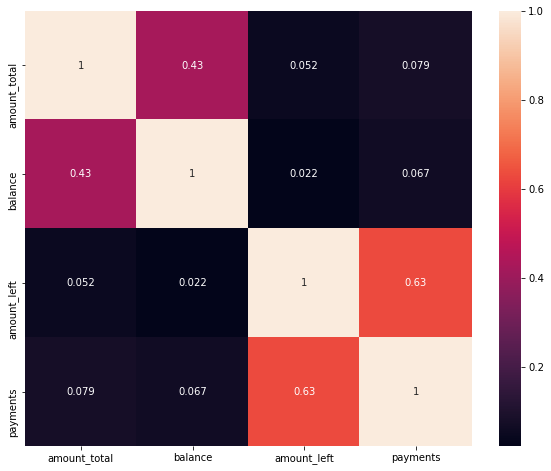

In [9]:
# Checking for multicollinearity
plt.figure(figsize=(10, 8))
ax = sns.heatmap(data.corr(), annot=True)
plt.show()

payments and amount_left have a rather high correlation, so we will include only one of them in the model

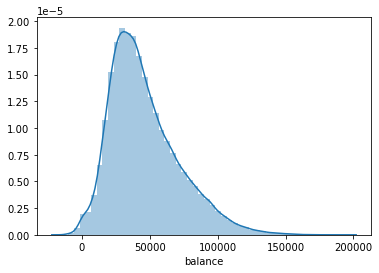

In [10]:
#sns.distplot(data['t_amount'])
#plt.show()

sns.distplot(data['balance'])
plt.show()

#sns.distplot(data['payments'])
#plt.show()

### Preprocessing the numerical variables

In [11]:
from sklearn.preprocessing import StandardScaler
data_num = data.select_dtypes(include = np.number).drop(columns = 'amount_left')
print(data_num.head())
# Normalizing data
transformer = StandardScaler().fit(data_num)
data_num_standardized = transformer.transform(data_num)
x = pd.DataFrame(data_num_standardized, columns = data_num.columns)
print(x.head())

   amount_total  balance  payments
0       44749.0  45549.0    3317.0
1        1000.0   1000.0    4399.0
2        1100.0   1100.0     609.0
3         700.0    700.0    1921.0
4         900.0    900.0    3492.0
   amount_total   balance  payments
0      3.147453 -0.018599 -0.471289
1     -0.582545 -1.769754  0.019231
2     -0.574019 -1.765823 -1.698947
3     -0.608123 -1.781547 -1.104158
4     -0.591071 -1.773685 -0.391953


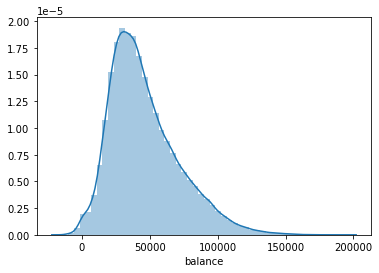

In [12]:
sns.distplot(data['balance'])
plt.show()

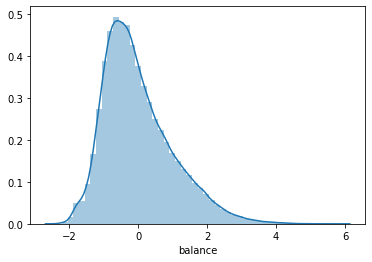

In [13]:
sns.distplot(x['balance'])
plt.show()

### Getting dummies for the categorical variables

In [14]:
from sklearn.preprocessing import OneHotEncoder
cat = data.select_dtypes(include = np.object).drop(columns = 'status')
enc = OneHotEncoder()
categorical = pd.DataFrame(enc.fit_transform(cat).toarray(), columns = enc.get_feature_names())
categorical.head()

,x0_PRIJEM,x0_VYBER,x0_VYDAJ,x1_prevod,x1_unknown,x1_vklad,x1_vyber,x2_pojistne,x2_sankc. urok,x2_sipo,x2_sluzby,x2_unknown,x2_urok,x2_uver,x3_12,x3_24,x3_36,x3_48,x3_60
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [15]:
categorical.sum(axis = 1)

0        4.0
1        4.0
2        4.0
3        4.0
4        4.0
        ... 
74359    4.0
74360    4.0
74361    4.0
74362    4.0
74363    4.0
Length: 74364, dtype: float64

In [16]:
y = data['status']
X = pd.concat((x, categorical), axis=1)

#### Splitting into train and test set

In [44]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=100)
from sklearn.tree import DecisionTreeClassifier
decisiontree = DecisionTreeClassifier().fit(X_train, y_train)
predictions = decisiontree.predict(X_test)
decisiontree.score(X_test, y_test)

0.9947219794258052

### Logistic Regression

In [35]:
from sklearn.linear_model import LogisticRegression
logisticr = LogisticRegression(max_iter = 500).fit(X_train, y_train)

In [36]:
predictions = logisticr.predict(X_test)
logisticr.score(X_test, y_test)

0.8806226047199623

In [20]:
print(y_test.value_counts())

A    25839
B     3907
Name: status, dtype: int64


In [21]:
pd.Series(predictions).value_counts()

A    29118
B      628
dtype: int64

What happened in terms of the classes?

### Decision Tree

In [22]:
from sklearn.tree import DecisionTreeClassifier
decisiontree = DecisionTreeClassifier().fit(X_train, y_train)

In [23]:
predictions = decisiontree.predict(X_test)
decisiontree.score(X_test, y_test)

0.9945875075640422

In [24]:
pd.Series(predictions).value_counts()

A    25814
B     3932
dtype: int64

In [25]:
decisiontree.feature_importances_

array([1.44719826e-02, 1.23030199e-01, 6.53878556e-01, 1.19579297e-03,
       5.94555031e-04, 5.44627412e-04, 2.18862787e-03, 1.82243949e-05,
       1.38950178e-03, 6.04106177e-04, 4.77936035e-04, 0.00000000e+00,
       5.19590488e-04, 1.04803477e-04, 5.62499912e-04, 1.39186287e-03,
       1.31004346e-04, 8.09413108e-02, 7.59626437e-02, 1.45125491e-02,
       9.69774718e-03, 1.77818787e-02])

In [26]:
print(dict(zip(X.columns, decisiontree.feature_importances_)))

{'amount_total': 0.01447198257568133, 'balance': 0.1230301988133862, 'payments': 0.6538785564425121, 'x0_PRIJEM': 0.001195792972895088, 'x0_VYBER': 0.0005945550310770405, 'x0_VYDAJ': 0.0005446274123990215, 'x1_prevod': 0.0021886278685564623, 'x1_unknown': 1.8224394948681073e-05, 'x1_vklad': 0.0013895017846856659, 'x1_vyber': 0.000604106176730246, 'x2_pojistne': 0.0004779360348858446, 'x2_sankc. urok': 0.0, 'x2_sipo': 0.000519590488138483, 'x2_sluzby': 0.00010480347703821306, 'x2_unknown': 0.0005624999119160343, 'x2_urok': 0.0013918628684922608, 'x2_uver': 0.00013100434629776634, 'x3_12': 0.08094131075679292, 'x3_24': 0.07596264370166515, 'x3_36': 0.014512549070533067, 'x3_48': 0.009697747177566456, 'x3_60': 0.01778187869380181}


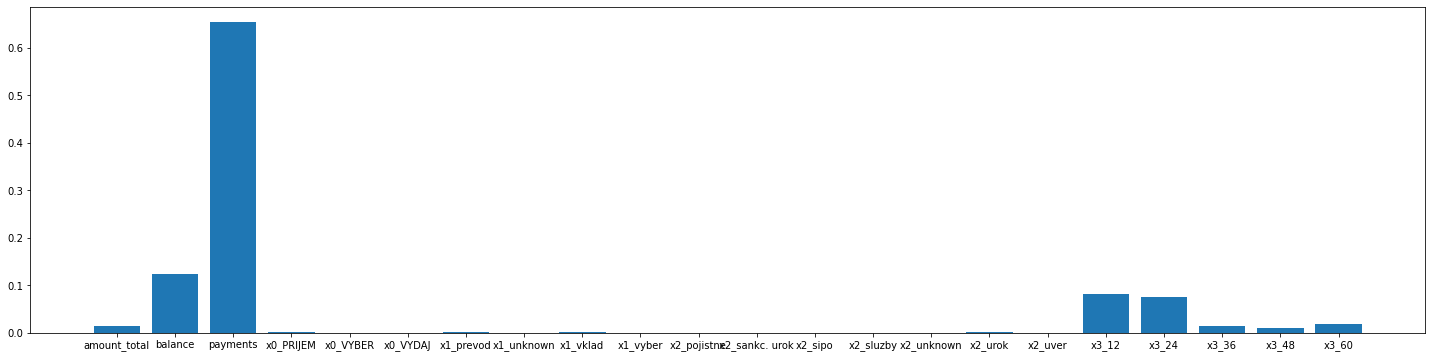

In [27]:
plt.rcParams['figure.figsize'] = [25, 6]
plt.bar(height = decisiontree.feature_importances_, x = X.columns)
plt.show()